In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from cmocean import cm
import scipy.stats as stat

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas7/grid.nc')

In [3]:
def calc_stats(x, y):
    stats = {}
    MSE = np.nanmean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.nanmean(y) - np.nanmean(x)
    stats['WSS'] = 1 - MSE / np.nanmean((abs(y - np.nanmean(x)) + abs(x - np.nanmean(x)))**2)
    
    return stats

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.2f} {units}\nbias = {stats['bias']:.2f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0, 0.8, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c


In [4]:
ctd2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2013.p')
ctd2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2014.p')
ctd2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2015.p')
ctd2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2016.p')
ctd2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2017.p')
ctd2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2018.p')
ctd2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2019.p')
ctd2020 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2020.p')
ctd2021 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2021.p')
ctd2022 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2022.p')
ctd2023 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2023.p')



In [5]:
bot2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2013.p')
bot2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2014.p')
bot2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2015.p')
bot2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2016.p')
bot2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2017.p')
bot2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2018.p')
bot2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2019.p')
bot2020 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2020.p')
bot2021 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2021.p')
bot2022 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2022.p')
bot2023 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2023.p')


In [6]:
obs = pd.concat([bot2013['obs'], bot2014['obs'], bot2015['obs'], bot2016['obs'], bot2017['obs'], bot2018['obs'], bot2019['obs'],
    bot2020['obs'], bot2021['obs'], bot2022['obs'], bot2023['obs']], ignore_index=True)
obs.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
obs = pd.concat([obs,ctd2013['obs'], ctd2014['obs'], ctd2015['obs'], ctd2016['obs'], ctd2017['obs'], ctd2018['obs'], ctd2019['obs'],
    ctd2020['obs'],ctd2021['obs'],ctd2022['obs'],ctd2023['obs'],], ignore_index=True)
obs.head()

,cid,lon,lat,time,z,SA,CT,DO (uM),NO3 (uM),Chl (mg m-3),name,cruise,source,NO2 (uM),NH4 (uM),PO4 (uM),SiO4 (uM),TA (uM),DIC (uM)
0,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-4.858567,29.526436,8.481087,217.480499,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-25.084826,29.931217,8.744595,194.705338,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-49.770050,30.161832,8.232655,199.617615,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-99.627083,31.185733,9.074455,7.145150,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-148.778397,31.455940,9.045912,5.805434,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# remove all unreasonable DO values, based on calculated max DO
obs.loc[obs['DO (uM)'] > 475, 'DO (uM)'] = pd.NA

# remove negative NO3 and Chl
obs.loc[obs['NO3 (uM)'] < 0, 'NO3 (uM)'] = pd.NA
obs.loc[obs['Chl (mg m-3)'] < 0, 'Chl (mg m-3)'] = pd.NA


Text(0, 0.5, 'Monthly count')

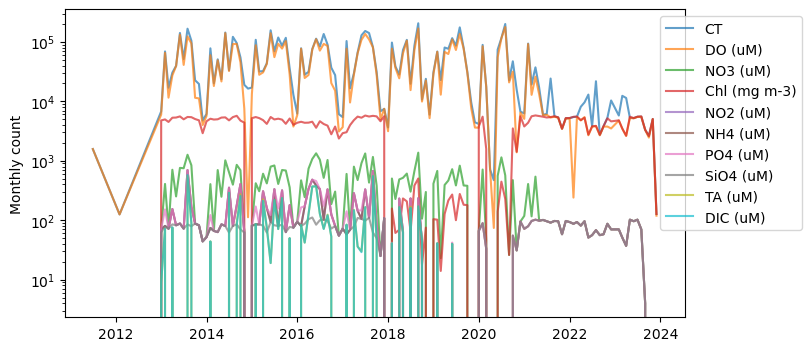

In [8]:
# lets see how the count of data changes with time, seperated by what was measured
# Extract both month and year from the 'time' column
obs['year_month'] = obs['time'].dt.to_period('M')  # This creates a Period object 'YYYY-MM'
obs['year_month'] = obs['year_month'].dt.to_timestamp()

# Columns to count non-NaN entries
columns_to_count = [
    'SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 
    'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)'
]

# Group by 'year_month' and count non-NaN entries for each column
monthly_counts = obs.groupby('year_month')[columns_to_count].count()

# plot
fig, ax = plt.subplots(1,1,figsize=[8,4])

for var in monthly_counts.columns[1:]:
    ax.plot(monthly_counts.index, monthly_counts[var], label=var,alpha=0.7)

ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.2, 1.0))
ax.set_ylabel('Monthly count')


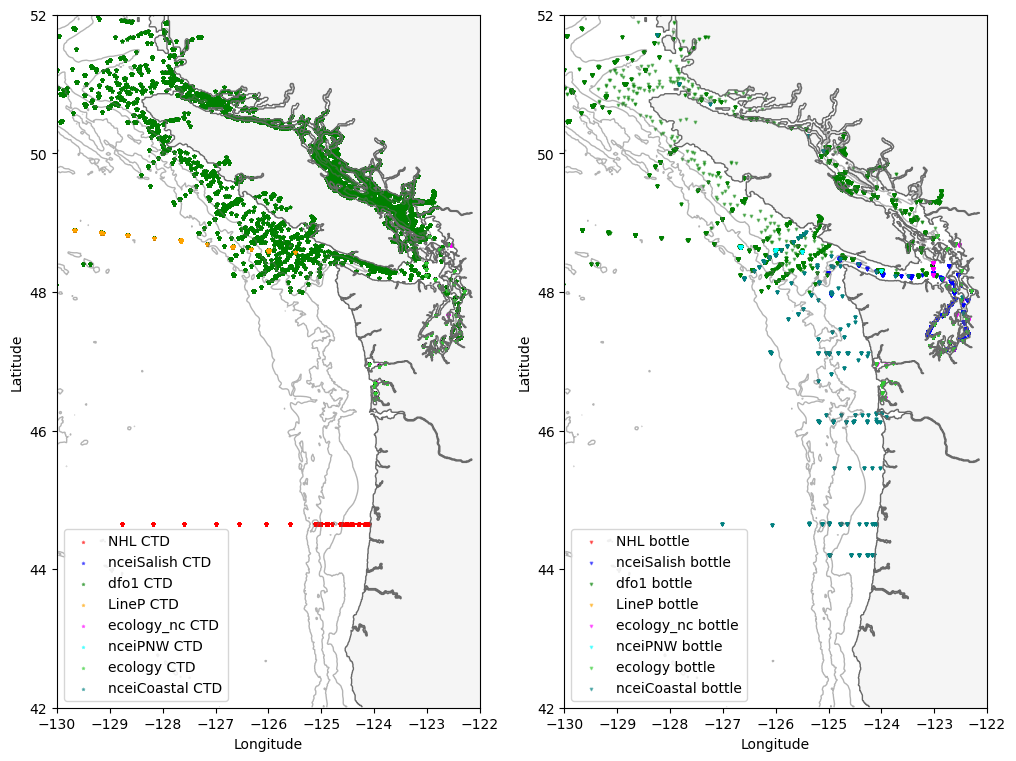

In [9]:
# plot by source
fig, ax = plt.subplots(1,2,figsize=(12, 9))

for axs in ax:
    axs.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
    axs.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
    axs.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
    axs.set_ylabel('Latitude')
    axs.set_xlabel('Longitude')
    axs.set_ylim([42,52])
    axs.set_xlim([-130,-122])


# plot the location of observations
clist = ['r','b','g','orange','magenta','cyan','limegreen','teal']
k=0
for source in list(set(obs.source)):
    ax[0].scatter(obs.lon[(obs.source==source) & (obs.name != 'bottle')], obs.lat[(obs.source==source) & (obs.name != 'bottle')], s=3, marker='*', color=clist[k], alpha=0.5, label="{} CTD".format(source))
    k+=1
k=0
for source in list(set(obs.source)):
    ax[1].scatter(obs.lon[(obs.source==source) & (obs.name == 'bottle')], obs.lat[(obs.source==source) & (obs.name == 'bottle')], marker='v',s=3, color=clist[k], alpha=0.5, label="{} bottle".format(source))
    k+=1
ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)



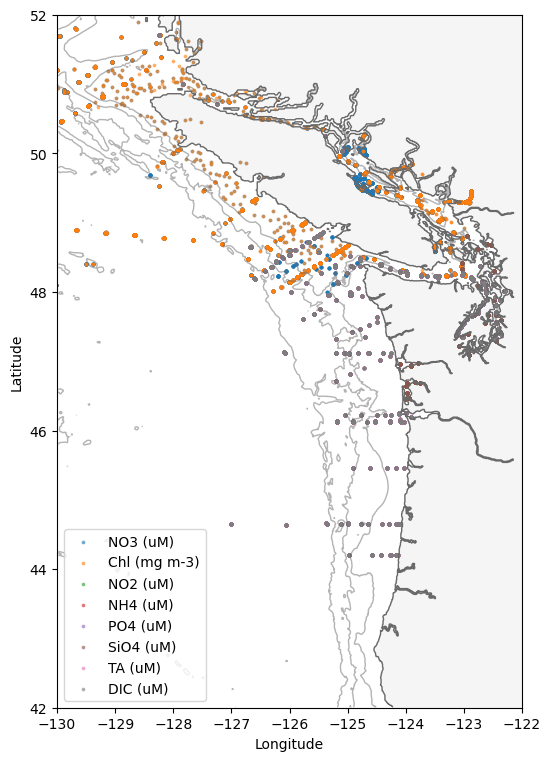

In [10]:
# plot by tracer (except SA and CT)
fig, ax = plt.subplots(1,1,figsize=(6, 9))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
tracers = ['NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)']
k=0
for t in tracers:
    ax.scatter(obs.lon[~np.isnan(obs[t])], obs.lat[~np.isnan(obs[t])], s=3, alpha=0.5, label=t)
    k+=1
k=0
ax.legend()

In [11]:
mod = pd.concat([bot2013['cas7_t0_x4b'], bot2014['cas7_t0_x4b'], bot2015['cas7_t0_x4b'], bot2016['cas7_t0_x4b'], bot2017['cas7_t0_x4b'], bot2018['cas7_t0_x4b'],bot2019['cas7_t0_x4b'],
    bot2020['cas7_t0_x4b'],bot2021['cas7_t0_x4b'],bot2022['cas7_t0_x4b'],bot2023['cas7_t0_x4b']], ignore_index=True)
mod.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
mod = pd.concat([mod,ctd2013['cas7_t0_x4b'], ctd2014['cas7_t0_x4b'], ctd2015['cas7_t0_x4b'], ctd2016['cas7_t0_x4b'], ctd2017['cas7_t0_x4b'], ctd2018['cas7_t0_x4b'], ctd2019['cas7_t0_x4b'],
    ctd2020['cas7_t0_x4b'],ctd2021['cas7_t0_x4b'],ctd2022['cas7_t0_x4b'],ctd2023['cas7_t0_x4b']], ignore_index=True)
mod.head()

,cid,cruise,time,lat,lon,name,z,source,h,CT,SA,Chl (mg m-3),DO (uM),NO3 (uM),NO2 (uM),NH4 (uM),TA (uM),DIC (uM)
0,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-4.858567,dfo1,172.824,7.463596,28.046377,0.022344,268.725586,22.274712,NaN,0.031271,2037.990356,1959.521118
1,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-25.084826,dfo1,172.824,8.601436,29.419864,0.003724,233.922440,23.146416,NaN,0.013879,2114.631836,2037.126221
2,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-49.770050,dfo1,172.824,8.905677,30.064023,0.002670,209.733170,23.892056,NaN,0.011508,2147.557129,2075.040283
3,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-99.627083,dfo1,172.824,8.914655,30.125749,0.002726,207.064545,23.977772,NaN,0.012508,2149.803711,2078.231689
4,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-148.778397,dfo1,172.824,8.660801,30.113303,0.003090,218.088181,23.586140,NaN,0.027075,2149.161865,2074.113037


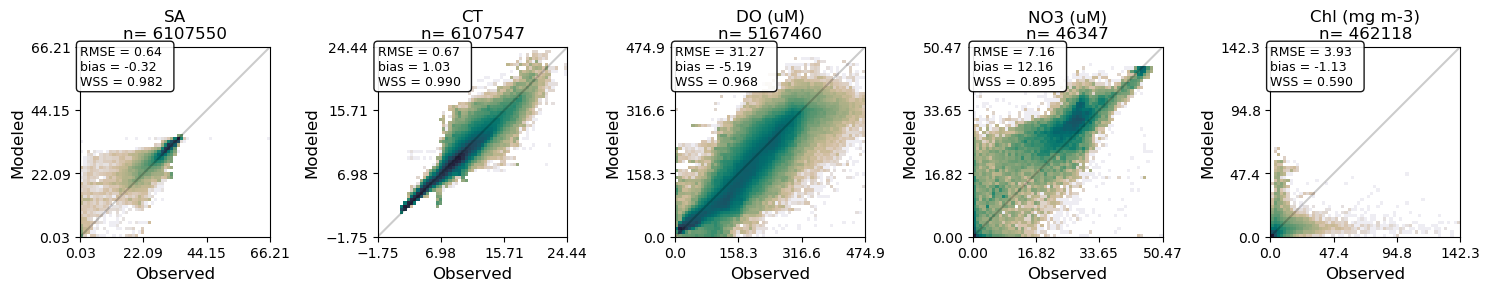

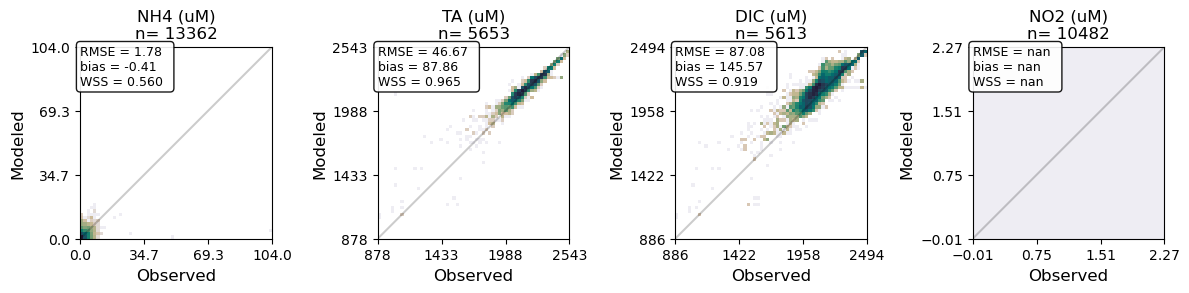

In [12]:
# eval over entire model domain
tracers = ['SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)',] 

cmap = cm.rain

fig, axs = plt.subplots(1, len(tracers), figsize = (3*len(tracers), 3)) 

for i in range(len(tracers)):
    vmin, vmax = np.min(obs[tracers[i]]), np.max(obs[tracers[i]])
    bin = np.linspace(vmin,vmax,60)

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]]))&(~np.isnan(mod[tracers[i]]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs.loc[iiS,[tracers[i]]].values.flatten(),
                                        mod.loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin, vmax, 4)
    # axs[i].set_xlim((27,35))
    # axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracers[i]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]], mod[tracers[i]], (vmin,vmax), ' ')

plt.tight_layout()

tracers = ['NH4 (uM)', 'TA (uM)', 'DIC (uM)', 'NO2 (uM)']
fig, axs = plt.subplots(1, len(tracers), figsize = (3*len(tracers), 3)) 

for i in range(len(tracers)):
    vmin, vmax = np.min(obs[tracers[i]]), np.max(obs[tracers[i]])
    bin = np.linspace(vmin,vmax,60)

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]]))&(~np.isnan(mod[tracers[i]]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs.loc[iiS,[tracers[i]]].values.flatten(),
                                        mod.loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin, vmax, 4)
    # axs[i].set_xlim((27,35))
    # axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracers[i]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]], mod[tracers[i]], (vmin,vmax), ' ')

plt.tight_layout()

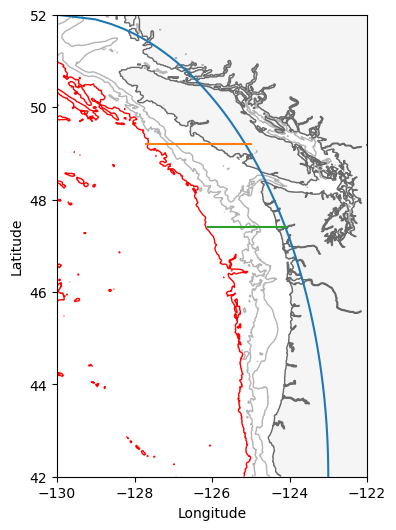

In [13]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')

fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[2000], colors='r')

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# salish sea cuttoff
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(10**2))*(7**2))-130
ax.plot(x,y)

#north cuttoff
ax.plot([-127.7,-125],[49.2,49.2])

# south cuttoff
ax.plot([-126.1,-124.1],[47.4,47.4])

In [14]:
m = -0.83
b = 48.4-(-124.6)*m

# code for seperating observations into groups based on location and depth
# def region(lat,lon,h,d,sal):
#     if lon > (lat-b)/m
#         return 'salish sea'
#     elif sal <= 31.5:
#         return 'brackish'
#     elif h >= 2000:
#         if d >= 120:
#             return 'offshore deep'
#         else:
#             return 'offshore surface'
#     elif h < 2000 and lat > 49:
#         return 'north'
#     elif h < 2000 and lat > 49:
#         return 4 #south
#     else:
#         return 5 #domain

obs['region'] = 'none'
obs.region[(mod.h >= 2000) & (obs.z<=-120)] = 'Offshore deep'
obs.region[(mod.h >= 2000) & (obs.z>-120)] = 'Offshore surface'
obs.region[(mod.h < 200) & (obs.lat >= 49)] = 'North'
obs.region[(mod.h < 200) & (obs.lat <= 47.3)] = 'South'
obs.region[(mod.h >= 200) & (mod.h < 2000) & (obs.lat >= 49) & (obs.z >= -200)] = 'North'
obs.region[(mod.h >= 200) & (mod.h < 2000) & (obs.lat <= 47.3) & (obs.SA < 33.7)] = 'South'
obs.region[(mod.h >= 200) & (mod.h < 2000) & (obs.lat <= 50.5) & (obs.SA >= 33.7)] = 'CUC'
obs.region[obs.SA <= 31.5] = 'Brackish' # putting this one last will remove the <32 points from the other regions
obs.region[obs.lon > (obs.lat-b)/m] = 'Salish'

# to deal with some south and cuc values with h=nan for whatever reason
obs.region[(obs.region == 'none') & (obs.lat < 46) & (obs.z > -200)] = 'South'
obs.region[(obs.region == 'none') & (obs.lat < 46) & (obs.z <= -200)] = 'CUC'

# to differentiate between domain and the rest of the 'none' values
obs.region[(obs.region == 'none') & (obs.lat > 47.3) & (obs.lat < 49) & (obs.lon > -127)] = 'Domain'

mod['region'] = obs.region

regions = list(set(obs.region))

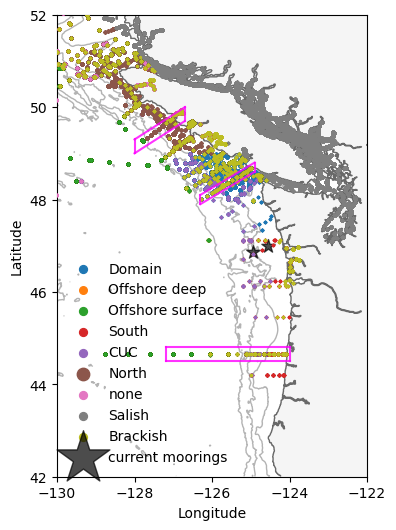

In [ ]:
# quick visual check to see if seperated properly
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke',zorder=1)
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray', zorder=2)
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5, zorder=0)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
for reg in regions:
    ax.scatter(obs.lon[obs.region == reg], obs.lat[obs.region == reg], s=2, label=reg,zorder=4)

# plot lil boxes around areas that you compare in crosssections.ipynb
#newport line?
plt.plot([-127.2,-124],[44.8,44.8],c='magenta',alpha=0.8,zorder=5)
plt.plot([-127.2,-124],[44.5,44.5],c='magenta',alpha=0.8,zorder=5)
plt.plot([-127.2,-127.2],[44.8,44.5],c='magenta',alpha=0.8,zorder=5)
plt.plot([-124,-124],[44.8,44.5],c='magenta',alpha=0.8,zorder=5)

#nice lil line near jdf entrance
plt.plot([-126.3,-126.3],[47.9,48.1],c='magenta',alpha=0.8,zorder=5)
plt.plot([-124.9,-124.9],[48.6,48.8],c='magenta',alpha=0.8,zorder=5)
plt.plot([-126.3,-124.9],[48.1,48.8],c='magenta',alpha=0.8,zorder=5)
plt.plot([-124.9,-126.3],[48.6,47.9],c='magenta',alpha=0.8,zorder=5)

#nice lil line a bit further up north
plt.plot([-128,-126.7],[49,49.7],c='magenta',alpha=0.8,zorder=5)
plt.plot([-128,-126.7],[49.3,50],c='magenta',alpha=0.8,zorder=5)
plt.plot([-126.7,-126.7],[49.7,50],c='magenta',alpha=0.8,zorder=5)
plt.plot([-128,-128],[49,49.3],c='magenta',alpha=0.8,zorder=5)

# make the markers for the stations in the timeseries analysis larger
plt.scatter([-124.56362,-124.9504],[46.98767,46.8545],c='k',s=100,marker='*',alpha=0.7, label="current moorings",zorder=3) 

lgnd= ax.legend(loc='lower left', markerscale=4, frameon=False)
# lgnd.legendHandles[1]._sizes = [30]
# lgnd.legendHandles[5]._sizes = [80]

In [16]:
# print the count of each
print(len(obs[obs.region == 'Offshore deep']), " = count offshore deep")
print(len(obs[obs.region == 'Offshore surface']), " = count offshore surface")
print(len(obs[obs.region == 'North']), " = count north")
print(len(obs[obs.region == 'South']), " = count south")
print(len(obs[obs.region == 'CUC']), " = count CUC")
print(len(obs[obs.region == 'Domain']), " = count domain")

940171  = count offshore deep
74719  = count offshore surface
116706  = count north
99200  = count south
671558  = count CUC
153754  = count domain


In [17]:
# make an array of the regions you're actually interested in looking at 
regions = ['North', 'Offshore deep', 'Offshore surface','South','CUC','Domain','Brackish']

# Observations versus model

In [18]:
tracers = ['SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'TA (uM)', 'DIC (uM)']

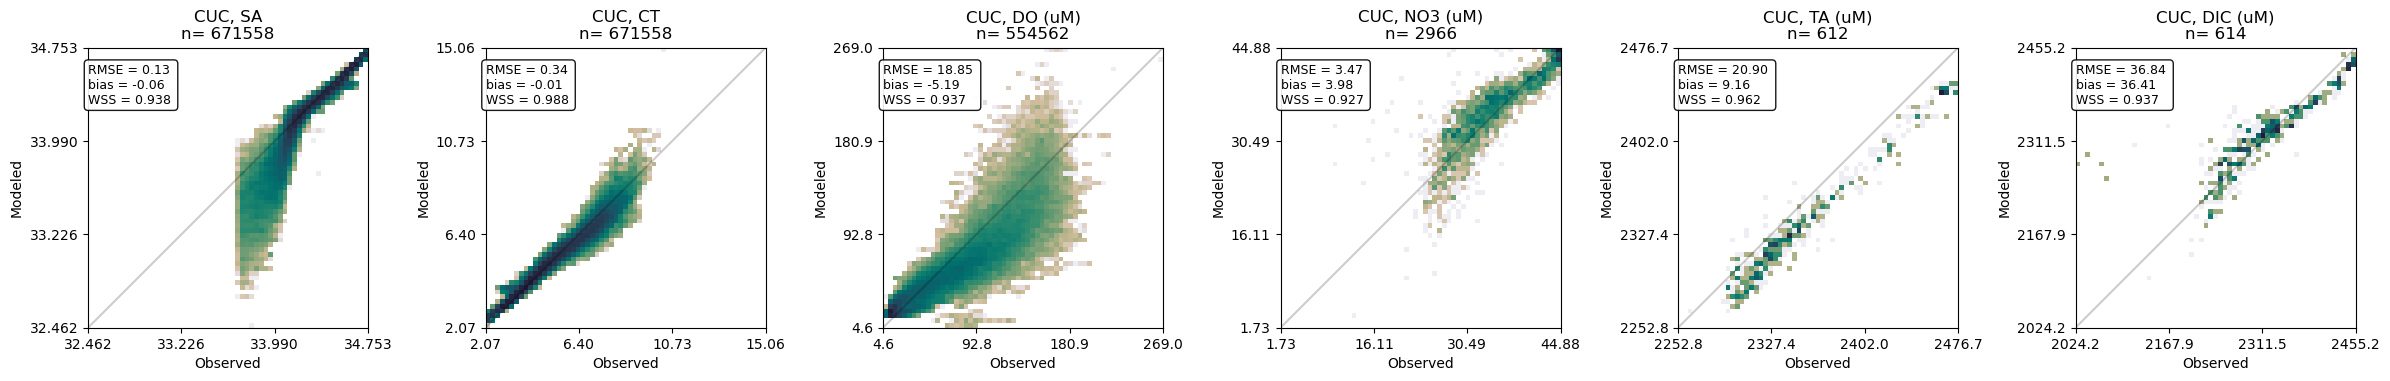

In [19]:
# what if evals by region instead since that's the way we're planning on writing about it..?

cmap = cm.rain

fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'CUC'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

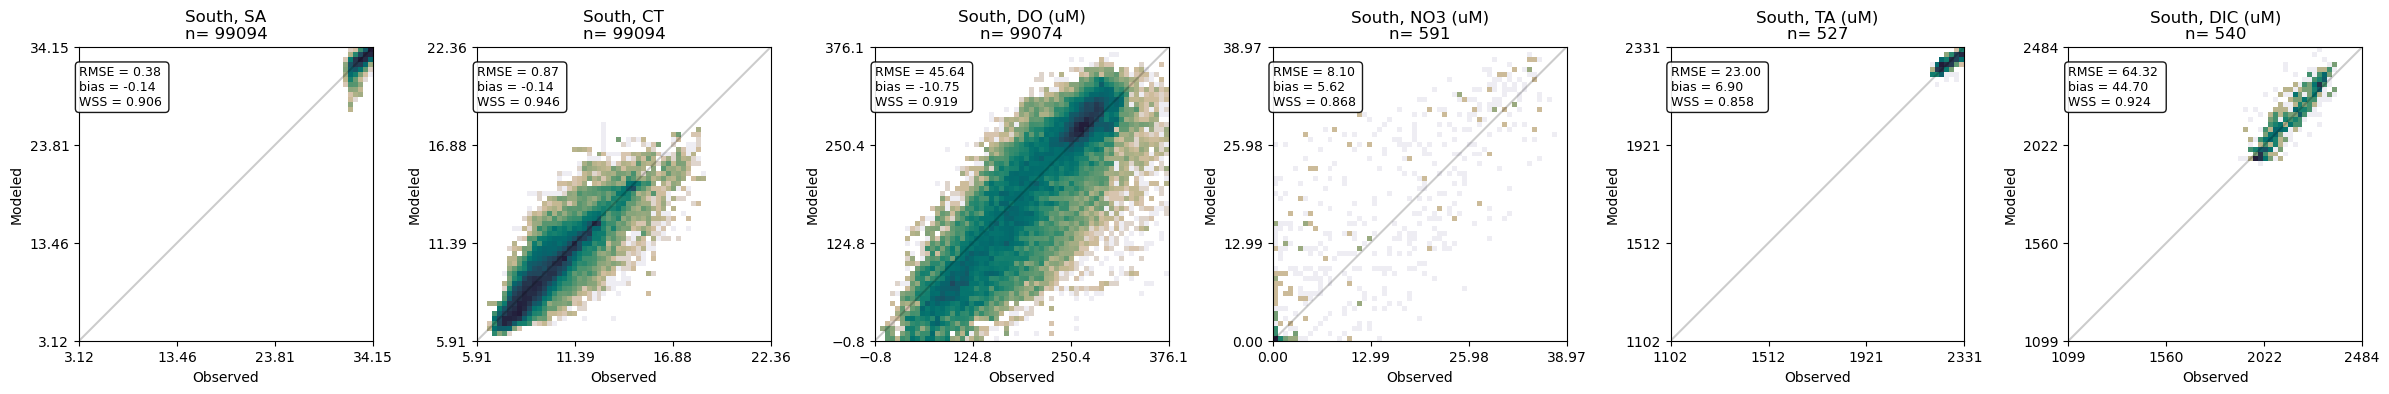

In [20]:
fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'South'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

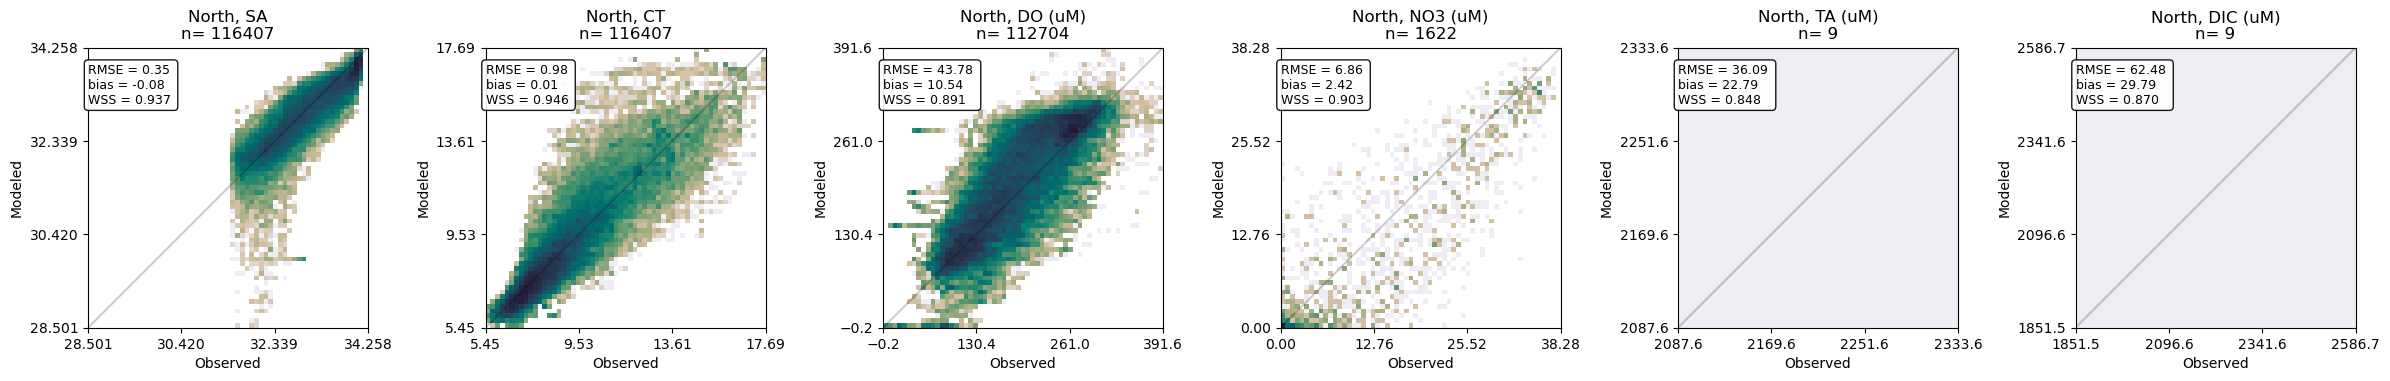

In [21]:
fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'North'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

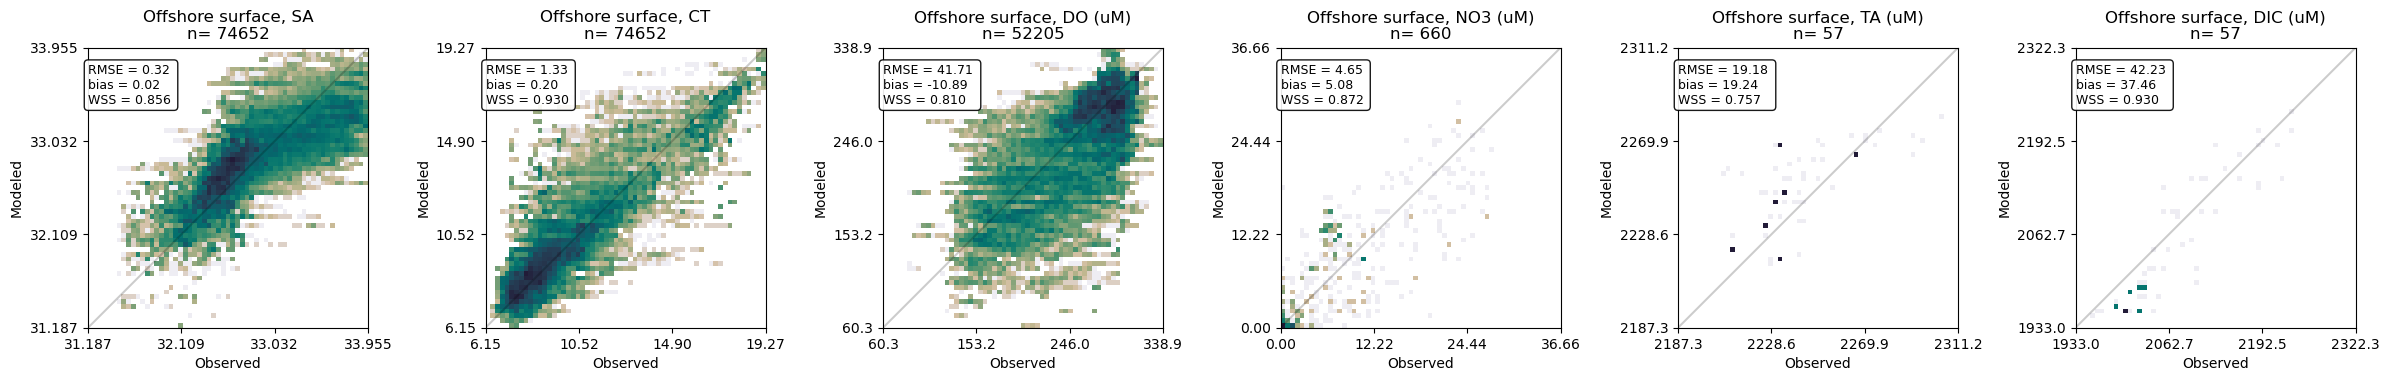

In [22]:
fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'Offshore surface'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

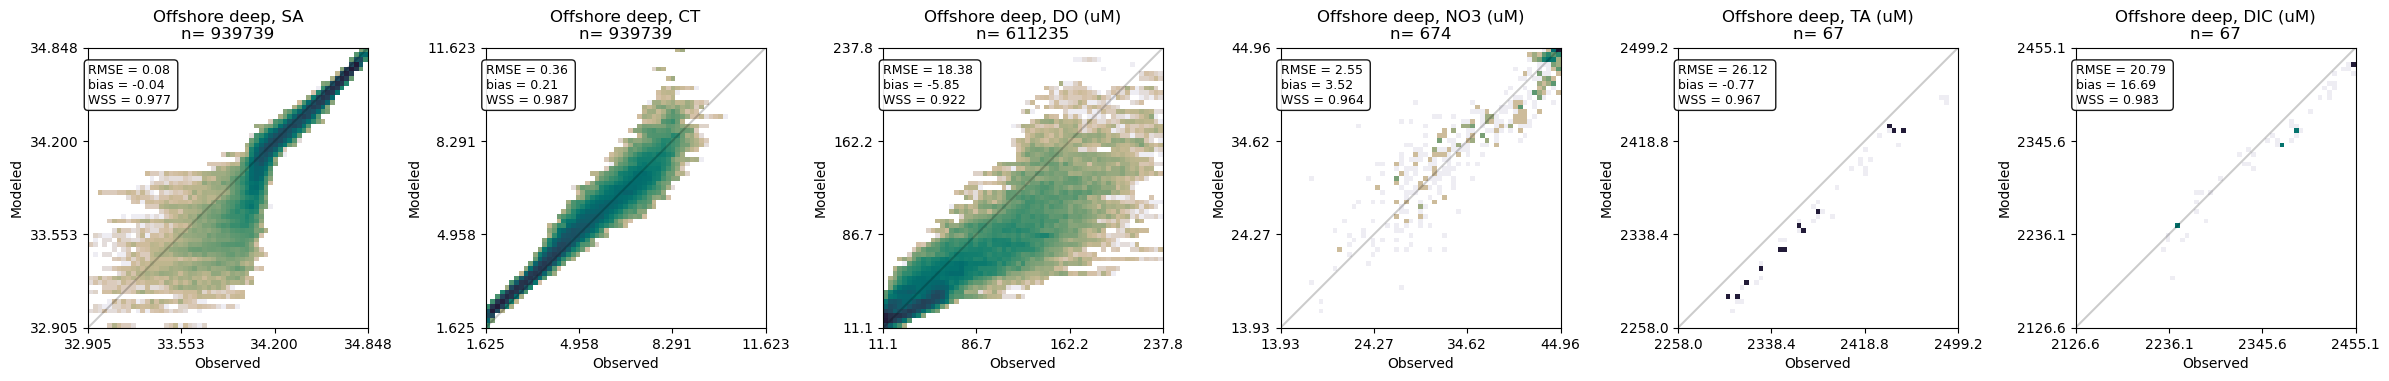

In [23]:
fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'Offshore deep'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

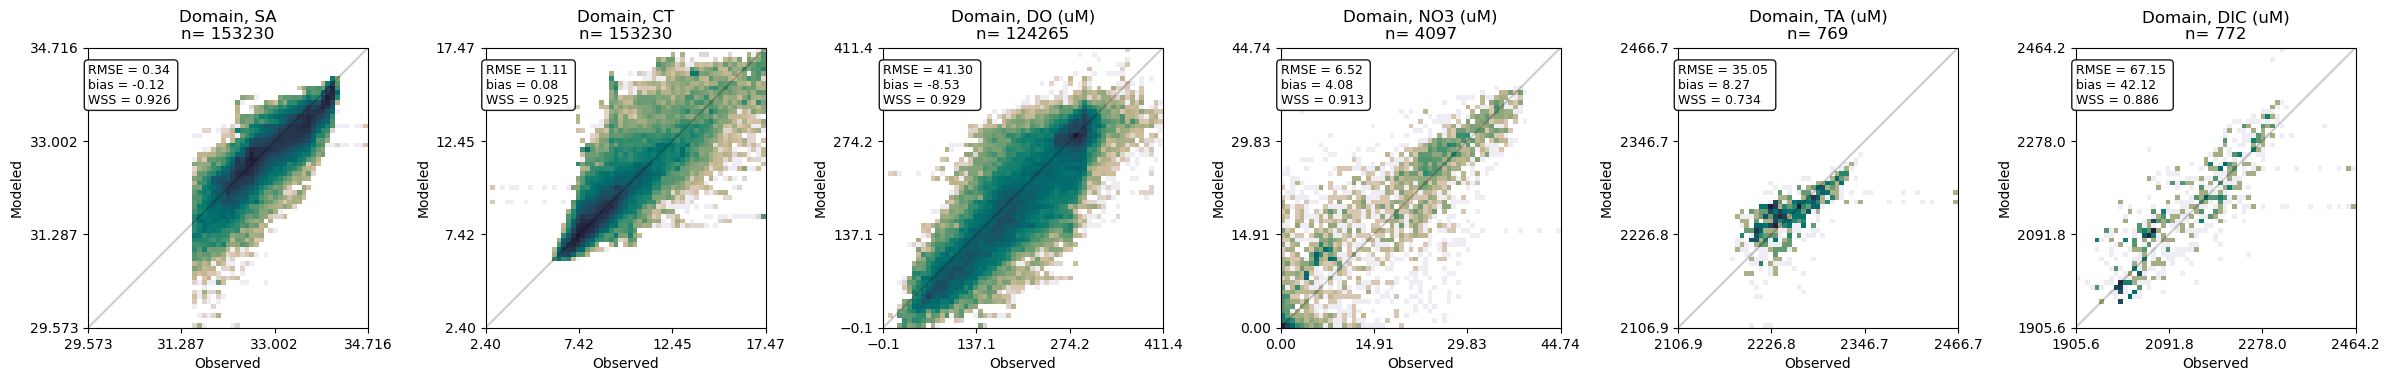

In [24]:
fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'Domain'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

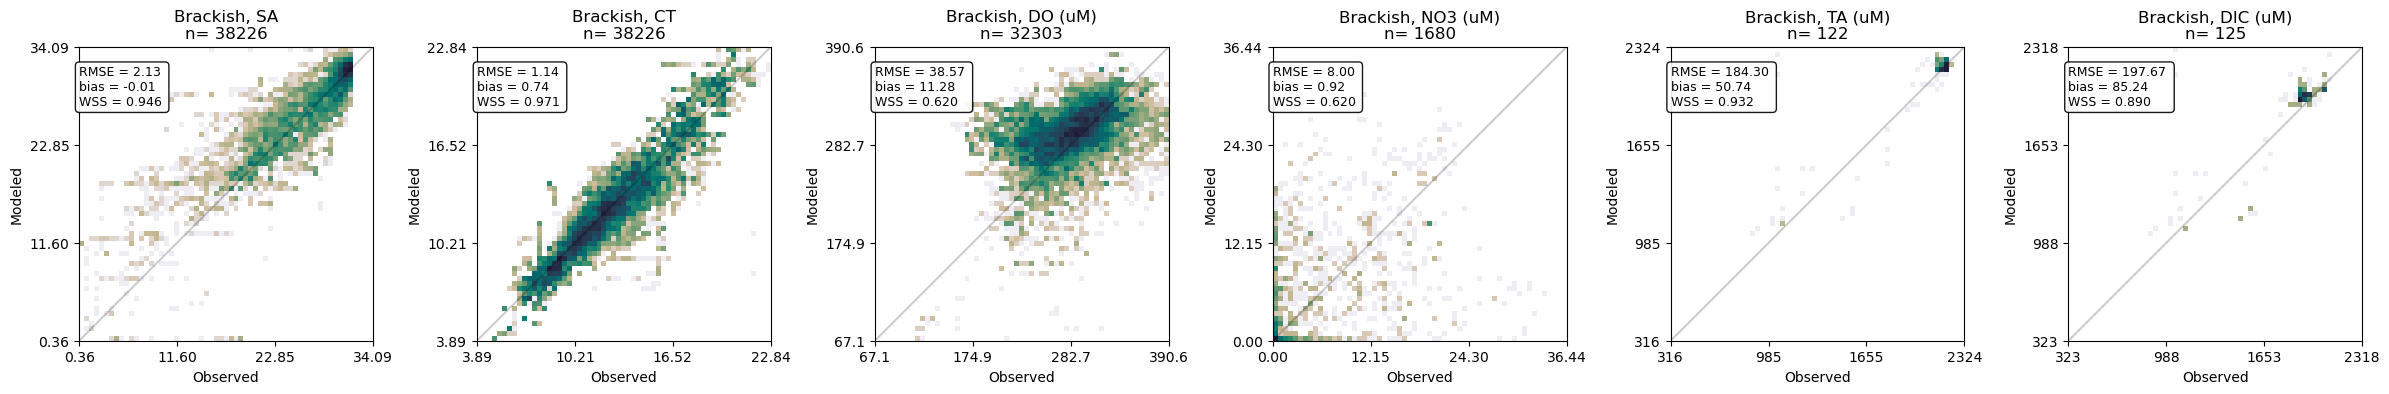

In [25]:
fig, axs = plt.subplots(1, len(tracers), figsize = (24, 4)) 

reg = 'Brackish'
for i in range(len(tracers)):

    vmin, vmax = np.min(mod[tracers[i]][mod.region == reg]), np.max(mod[tracers[i]][mod.region == reg])
    bin = np.linspace(vmin,vmax,60)
    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]][obs.region == reg]))&(~np.isnan(mod[tracers[i]][mod.region == reg]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == reg].loc[iiS,[tracers[i]]].values.flatten(),
                                        mod[mod.region == reg].loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    ntick=np.linspace(vmin, vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled')
    axs[i].set_xlabel('Observed')

    title = reg + ', ' +tracers[i] +'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]][(obs.region == reg)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]][obs.region == reg], mod[tracers[i]][mod.region == reg], (vmin,vmax), '')

plt.tight_layout()

# Taylor Diagrams

In [26]:
'''
How to create a Taylor diagram with a color bar showing bias

Authors: Peter A. Rochford
         Andre D. L. Zanchetta

Created on Jan 13, 2019
Revised on Aug 28, 2022

@author: rochford.peter1@gmail.com
@author: adlzanchetta@gmail.com
'''
import skill_metrics as sm



In [90]:
def calculate_taylor_metrics(observed, modeled):
    """
    Calculate the standard deviation, centered RMSD, correlation coefficient, bias
    for Taylor diagram inputs.

    Parameters:
        observed (pd.Series): Observed data.
        modeled (pd.Series): Modeled data.

    Returns:
        tuple: (std_observed, std_modeled, crmsd, correlation)
    """
    # Remove missing values
    valid_data = pd.concat([observed, modeled], axis=1).dropna()
    obs = valid_data.iloc[:, 0]
    mod = valid_data.iloc[:, 1]

    # Standard deviation
    std = np.std(mod)/np.std(obs)

    # Correlation coefficient
    correlation = np.corrcoef(obs, mod)[0, 1]

    # Centered RMSD
    crmsd = np.sqrt(np.mean((obs - obs.mean() - (mod - mod.mean()))**2))

    # bias
    bias = np.nanmean(modeled) - np.nanmean(observed)

    return std, crmsd, correlation, bias
    

In [91]:
# ## DATA ####################################################################### #

SUBPLOTS_DATA = [
    {
        "axis_idx": (0, 0),
        "title": "(a) SA",
        "y_label": True,
        "x_label": False,
        "observed": (0,0,1),
        "modeled": {
            "Offshore surface": calculate_taylor_metrics(obs.SA[obs.region=='Offshore surface'], mod.SA[mod.region=='Offshore surface']),
            "Offshore deep": calculate_taylor_metrics(obs.SA[obs.region=='Offshore deep'], mod.SA[mod.region=='Offshore deep']),
            "North": calculate_taylor_metrics(obs.SA[obs.region=='North'], mod.SA[mod.region=='North']),
            "South": calculate_taylor_metrics(obs.SA[obs.region=='South'], mod.SA[mod.region=='South']),
            "CUC": calculate_taylor_metrics(obs.SA[obs.region=='CUC'], mod.SA[mod.region=='CUC']),
            "Domain": calculate_taylor_metrics(obs.SA[obs.region=='Domain'], mod.SA[mod.region=='Domain'])
        }
    }, {
        "axis_idx": (0, 1),
        "title": "(b) CT",
        "y_label": False,
        "x_label": False,
        "observed": (0,0,1),
        "modeled": {
            "Offshore surface": calculate_taylor_metrics(obs.CT[obs.region=='Offshore surface'], mod.CT[mod.region=='Offshore surface']),
            "Offshore deep": calculate_taylor_metrics(obs.CT[obs.region=='Offshore deep'], mod.CT[mod.region=='Offshore deep']),
            "North": calculate_taylor_metrics(obs.CT[obs.region=='North'], mod.CT[mod.region=='North']),
            "South": calculate_taylor_metrics(obs.CT[obs.region=='South'], mod.CT[mod.region=='South']),
            "CUC": calculate_taylor_metrics(obs.CT[obs.region=='CUC'], mod.CT[mod.region=='CUC']),
            "Domain": calculate_taylor_metrics(obs.CT[obs.region=='Domain'], mod.CT[mod.region=='Domain'])
        }
    }, {
        "axis_idx": (0, 2),
        "title": "(c) DO",
        "y_label": False,
        "x_label": False,
        "observed": (0,0,1),
        "modeled": {
            "Offshore surface": calculate_taylor_metrics(obs['DO (uM)'][obs.region=='Offshore surface'], mod['DO (uM)'][mod.region=='Offshore surface']),
            "Offshore deep": calculate_taylor_metrics(obs['DO (uM)'][obs.region=='Offshore deep'], mod['DO (uM)'][mod.region=='Offshore deep']),
            "North": calculate_taylor_metrics(obs['DO (uM)'][obs.region=='North'], mod['DO (uM)'][mod.region=='North']),
            "South": calculate_taylor_metrics(obs['DO (uM)'][obs.region=='South'], mod['DO (uM)'][mod.region=='South']),
            "CUC": calculate_taylor_metrics(obs['DO (uM)'][obs.region=='CUC'], mod['DO (uM)'][mod.region=='CUC']),
            "Domain": calculate_taylor_metrics(obs['DO (uM)'][obs.region=='Domain'], mod['DO (uM)'][mod.region=='Domain'])
        }
    }, {
        "axis_idx": (1, 0),
        "title": "(d) $NO_3$",
        "y_label": True,
        "x_label": False,
        "observed": (0,0,1),
        "modeled": {
            "Offshore surface": calculate_taylor_metrics(obs['NO3 (uM)'][obs.region=='Offshore surface'], mod['NO3 (uM)'][mod.region=='Offshore surface']),
            "Offshore deep": calculate_taylor_metrics(obs['NO3 (uM)'][obs.region=='Offshore deep'], mod['NO3 (uM)'][mod.region=='Offshore deep']),
            "North": calculate_taylor_metrics(obs['NO3 (uM)'][obs.region=='North'], mod['NO3 (uM)'][mod.region=='North']),
            "South": calculate_taylor_metrics(obs['NO3 (uM)'][obs.region=='South'], mod['NO3 (uM)'][mod.region=='South']),
            "CUC": calculate_taylor_metrics(obs['NO3 (uM)'][obs.region=='CUC'], mod['NO3 (uM)'][mod.region=='CUC']),
            "Domain": calculate_taylor_metrics(obs['NO3 (uM)'][obs.region=='Domain'], mod['NO3 (uM)'][mod.region=='Domain'])
        }
    }, {
        "axis_idx": (1, 1),
        "title": "(e) TA",
        "y_label": False,
        "x_label": False,
        "observed": (0,0,1),
        "modeled": {
            "Offshore surface": calculate_taylor_metrics(obs['TA (uM)'][obs.region=='Offshore surface'], mod['TA (uM)'][mod.region=='Offshore surface']),
            "Offshore deep": calculate_taylor_metrics(obs['TA (uM)'][obs.region=='Offshore deep'], mod['TA (uM)'][mod.region=='Offshore deep']),
            "North": calculate_taylor_metrics(obs['TA (uM)'][obs.region=='North'], mod['TA (uM)'][mod.region=='North']),
            "South": calculate_taylor_metrics(obs['TA (uM)'][obs.region=='South'], mod['TA (uM)'][mod.region=='South']),
            "CUC": calculate_taylor_metrics(obs['TA (uM)'][obs.region=='CUC'], mod['TA (uM)'][mod.region=='CUC']),
            "Domain": calculate_taylor_metrics(obs['TA (uM)'][obs.region=='Domain'], mod['TA (uM)'][mod.region=='Domain'])
        }
    }, {
        "axis_idx": (1, 2),
        "title": "(f) DIC",
        "y_label": False,
        "x_label": False,
        "observed": (0,0,1),
        "modeled": {
            "Offshore surface": calculate_taylor_metrics(obs['DIC (uM)'][obs.region=='Offshore surface'], mod['DIC (uM)'][mod.region=='Offshore surface']),
            "Offshore deep": calculate_taylor_metrics(obs['DIC (uM)'][obs.region=='Offshore deep'], mod['DIC (uM)'][mod.region=='Offshore deep']),
            "North": calculate_taylor_metrics(obs['DIC (uM)'][obs.region=='North'], mod['DIC (uM)'][mod.region=='North']),
            "South": calculate_taylor_metrics(obs['DIC (uM)'][obs.region=='South'], mod['DIC (uM)'][mod.region=='South']),
            "CUC": calculate_taylor_metrics(obs['DIC (uM)'][obs.region=='CUC'], mod['DIC (uM)'][mod.region=='CUC']),
            "Domain": calculate_taylor_metrics(obs['DIC (uM)'][obs.region=='Domain'], mod['DIC (uM)'][mod.region=='Domain'])
        }
    }
]

In [100]:
# lets try to truncate the colourmap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap

# Function to truncate a colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'truncated({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Truncate the 'balance' colormap to exclude extreme colors
truncated_cmap = truncate_colormap(cm.balance, minval=0.1, maxval=0.9)

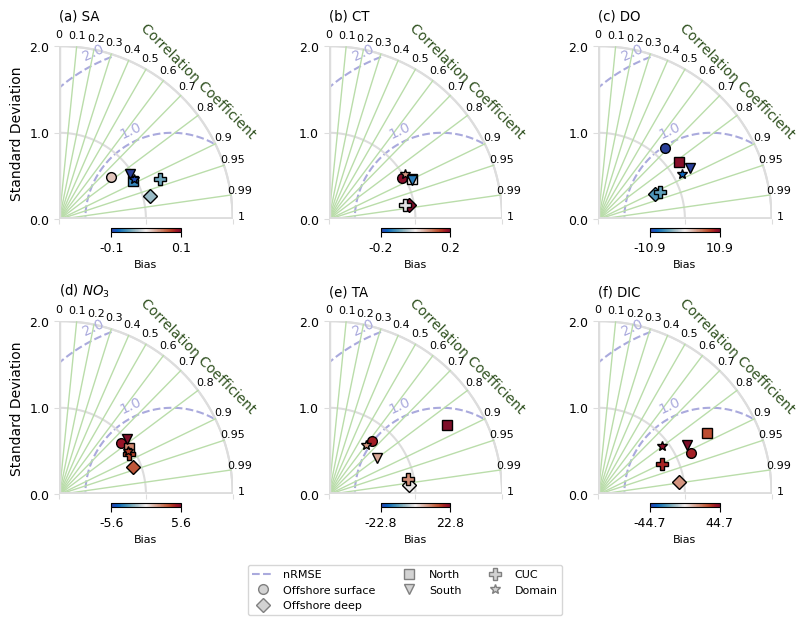

In [120]:
MARKERS = {
    "Offshore surface": {
        "marker": "o",
        "color_edge": "#000000",
        "color_face": "#777777",
        "markersize": 7
    },
    "Offshore deep": {
        "marker": "D",
        "color_edge": "#AA0000",
        "color_face": "#DD3333",
        "markersize": 7
    },
    "North": {
        "marker": "s",
        "color_edge": "#00AA00",
        "color_face": "#33DD33",
        "markersize": 7
    },
    "South": {
        "marker": "v",
        "color_edge": "#0000AA",
        "color_face": "#3333DD",
        "markersize": 7
    },
    "CUC": {
        "marker": "P",
        "color_edge": "#D4AF37",
        "color_face": "#FFD700",
        "markersize": 9
    },
    "Domain": {
        "marker": "*",
        "color_edge": "#D4AF37",
        "color_face": "#FFD700",
        "markersize": 7
    }
}


# ## PLOT STYLE ################################################################# #

FONT_SIZE = 9

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#baddaa',
    'tick_labels': '#000000',
    'title': '#315221'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#363535'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}

# ## MAIN ####################################################################### #

if __name__ == '__main__':

    # update figures global properties
    plt.rcParams.update({'font.size': FONT_SIZE-1})

    # create figure with 2 lines and 3 columns
    fig_size = (3*2.8, 2*2.8)
    fig, axs = plt.subplots(2, 3, figsize=fig_size)#, sharey=True)

    # build subplot by subplot
    for subplot_data in SUBPLOTS_DATA:
        
        # get subplot object and ensure it will be a square
        # y-axis labels will only appear on leftmost subplot
        ax = axs[subplot_data["axis_idx"][0]][subplot_data["axis_idx"][1]]
        # ax.set(adjustable='box', aspect='equal')
        
        stdev, crmsd, ccoef = 1.3, 0, 1
        # create the plot with the observed data
        sm.taylor_diagram(ax,
                          np.asarray((stdev, stdev)), 
                          np.asarray((crmsd, crmsd)), 
                          np.asarray((ccoef, ccoef)),
                          markercolors = {
                              "face": 'white',
                              "edge": 'white'
                              },
                          markersize = 0.1, markersymbol = '*', alpha = 0,
                          titleSTD = 'off', colsstd = COLS_STD, styleSTD='-',
                          titleRMS = 'off', colRMS = STYLES_RMS['color'], tickRMSangle = 115, styleRMS = STYLES_RMS['linestyle'],
                          titleCOR = 'on', titleCORshape='linear', colscor = COLS_COR, styleCOR='-', widthCOR=1.0,
                          showlabelsRMS = 'on',
                          colframe='#DDDDDD',
                          labelweight='normal')

        # define and plot colourbar
        biases =np.array([subplot_data['modeled'][key][-1] for key in subplot_data['modeled'].keys()])
        vmin, vmax = -np.max(abs(biases)), np.max(abs(biases))  # Set the range based on your data
        vcenter = 0  
        norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        cmap = truncated_cmap
        cb = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(cb, ax=ax, location='bottom', shrink=0.3, pad=0.04, orientation='horizontal',label='Bias')
        cbar.set_ticks([vmin, vmax])  # Only show labels at the ends
        cbar.set_ticklabels([f"{vmin:.1f}", f"{vmax:.1f}"])  # Format tick labels
        cbar.ax.tick_params(labelsize=FONT_SIZE)  # Adjust label size
        
        # create one overlay for each model marker
        for model_id, (stdev, crmsd, ccoef,bias) in subplot_data["modeled"].items():
            marker = MARKERS[model_id]
            colour = cmap(norm(bias))
            sm.taylor_diagram(ax,
                              np.asarray((stdev, stdev)),
                              np.asarray((crmsd, crmsd)),
                              np.asarray((ccoef, ccoef)),
                              markersymbol = marker["marker"],
                              markercolors = {
                                "face": colour,
                                "edge": 'k'
                              },
                              markersize = marker["markersize"],
                              alpha = 1.0,
                              overlay = 'on',
                              styleCOR = '-',
                              styleSTD = '-')

        # set titles (upper, left, bottom)
        ax.set_title(subplot_data["title"], loc="left", y=1.1)

        # add correlation coefficient label 
        # ax.text(32,32,'r',color='#315221',weight='bold',fontsize=FONT_SIZE+3)

        # add y label
        if subplot_data["y_label"]:
            ax.set_ylabel("Standard Deviation",
                          fontsize=FONT_SIZE+1)

        # add xlabel or hide xticklabels
        if subplot_data["x_label"]:
            ax.set_xlabel("Standard Deviation",
                          fontsize=FONT_SIZE+1)
        else:
            ax.set_xticklabels(ax.get_xticklabels(), color=ax.get_facecolor())

    # build legend handles    
    legend_handles = []
    legend_handles.append(mlines.Line2D([], [],
                          color=STYLES_RMS['color'],
                          linestyle=STYLES_RMS['linestyle'],
                          label="nRMSE"))

    for marker_label, marker_desc in MARKERS.items():
        marker = mlines.Line2D([], [], 
                               marker=marker_desc["marker"],
                               markersize=marker_desc["markersize"],
                               markerfacecolor='lightgray',
                               markeredgecolor='gray',
                               linestyle='None',
                               label=marker_label)
        legend_handles.append(marker)
        del marker_label, marker_desc, marker

    # Add a figure-wide legend below the subplots
    fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.001), frameon=True)

    # avoid some overlapping
    plt.tight_layout()

    plt.savefig('/data1/bbeutel/LO_user/ariane/figures/Taylor.pdf', bbox_inches='tight')

# Property-property plots
See if the same water masses show up even if the properties or locations don't match perfectly

In [28]:
def prop_prop(ax,stringX,stringY,x,y,binX,binY):
    cmap = cm.rain
    cmap.set_bad('w')
    # cmap.set_extremes(under='w')

    bins = [binX,binY]
    H, xedges, yedges=np.histogram2d(x,y,bins=bins)
    H = H.T
    H_final = np.where(H>0, H, H*np.nan)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=LogNorm(vmin=10, vmax=45000))
    ax.set_ylabel(stringY)
    ax.set_xlabel(stringX)


In [29]:
#set consistent bins
Tbin = np.linspace(0,20,100)
Sbin = np.linspace(25,37,100)
Dbin = np.linspace(0,350,100)

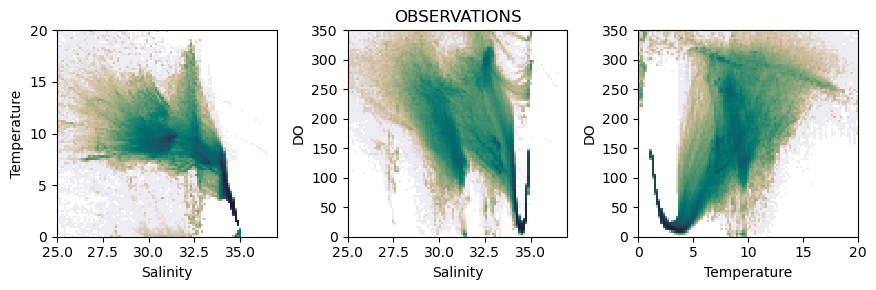

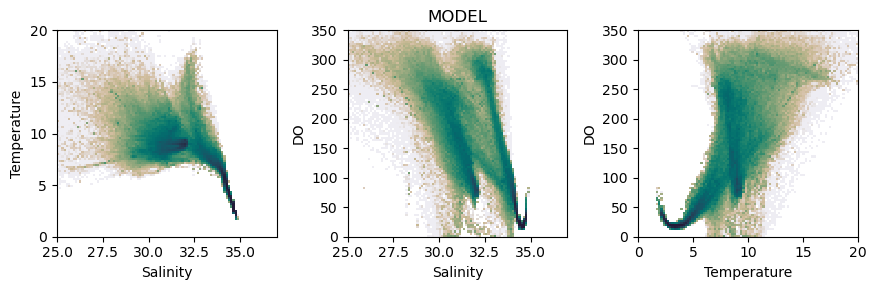

In [30]:
# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA,obs.CT,Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA,obs["DO (uM)"],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT,obs["DO (uM)"],Tbin,Dbin)
axs[1].set_title('OBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA,mod.CT,Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA,mod['DO (uM)'],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT,mod['DO (uM)'],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()


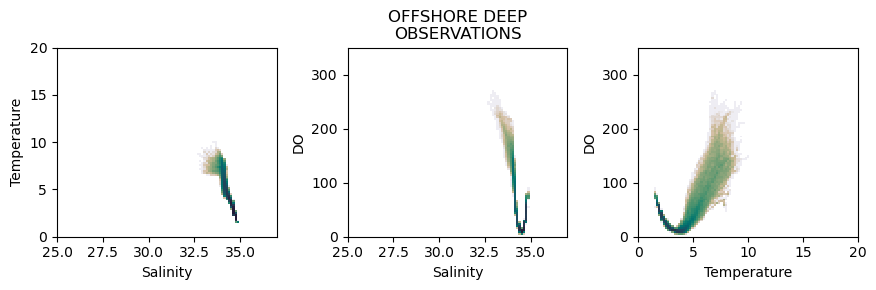

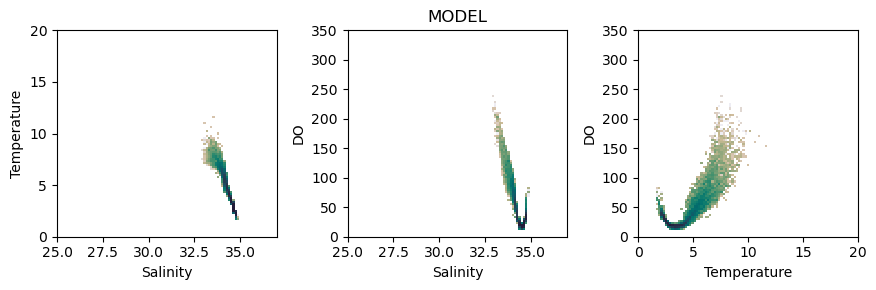

In [31]:
# same thing but by region
#OFFSHORE
r='Offshore deep'

# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('OFFSHORE DEEP\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

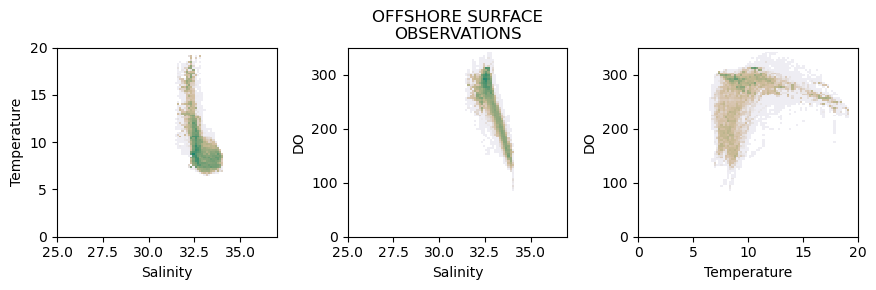

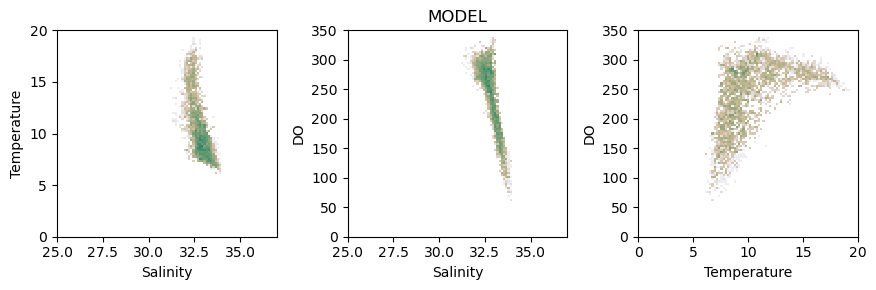

In [32]:
# same thing but by region
#OFFSHORE
r='Offshore surface'

# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('OFFSHORE SURFACE\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

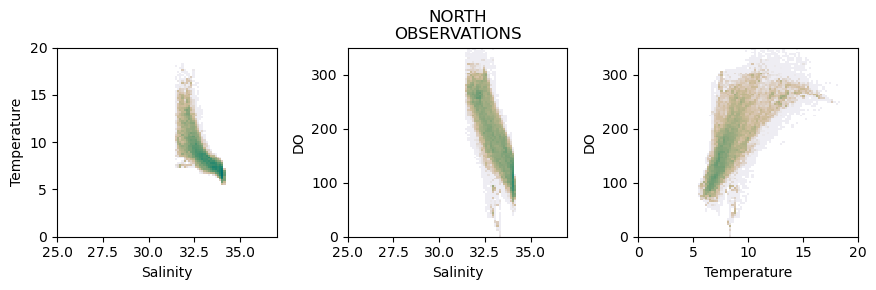

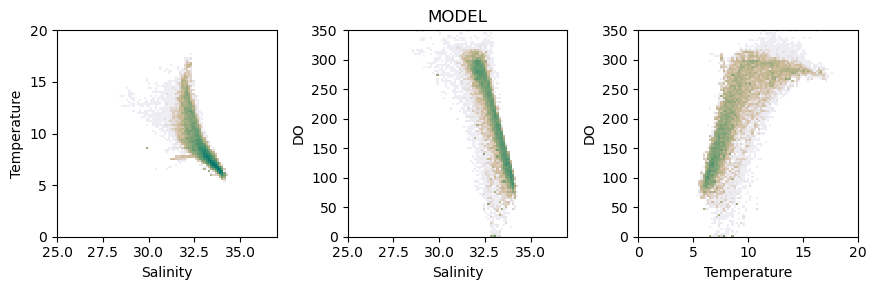

In [33]:
# same thing but by region
r='North'
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('NORTH\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

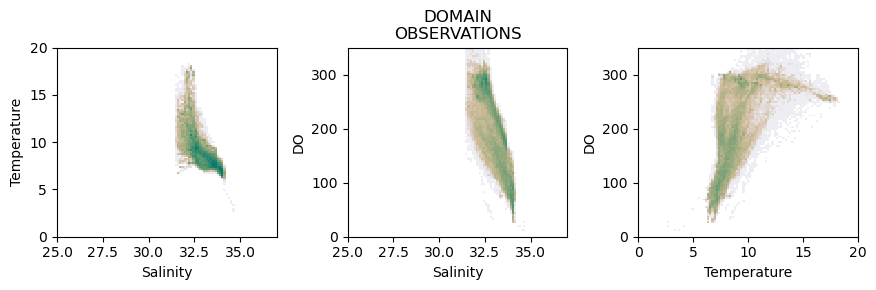

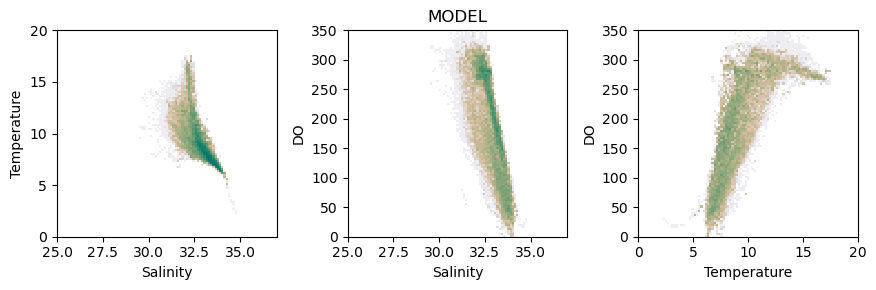

In [34]:
# same thing but by region
r='Domain'
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('DOMAIN\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

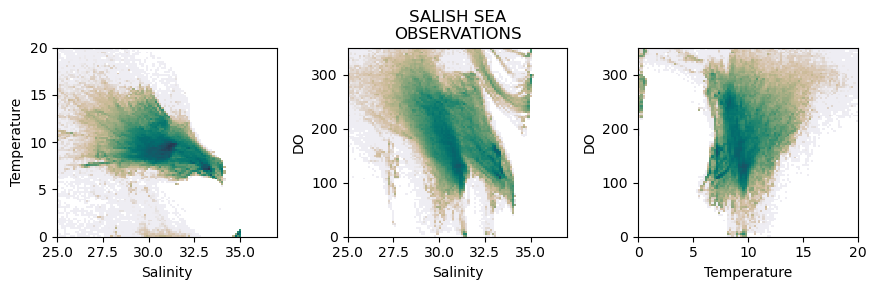

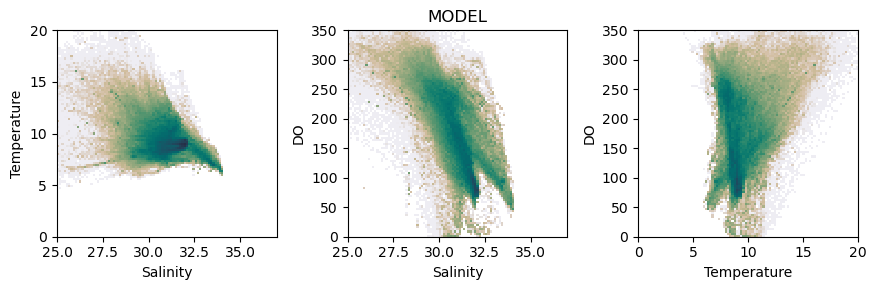

In [35]:
# same thing but by region
r='Salish'
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('SALISH SEA\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

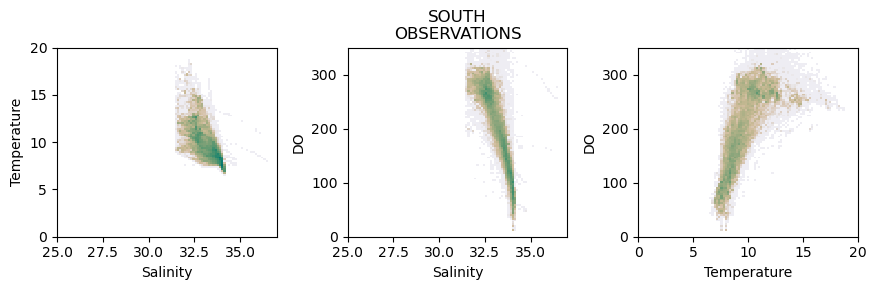

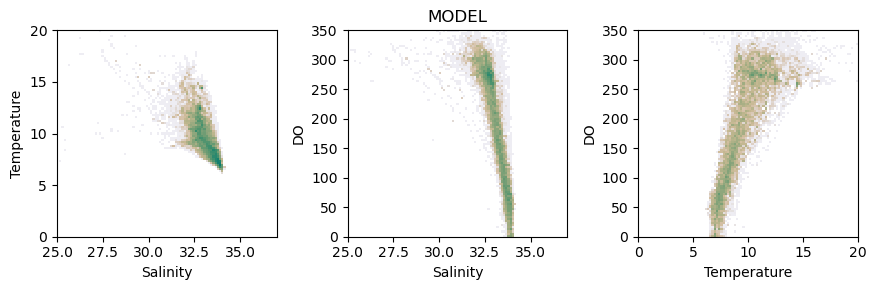

In [36]:
r='South'
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('SOUTH\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

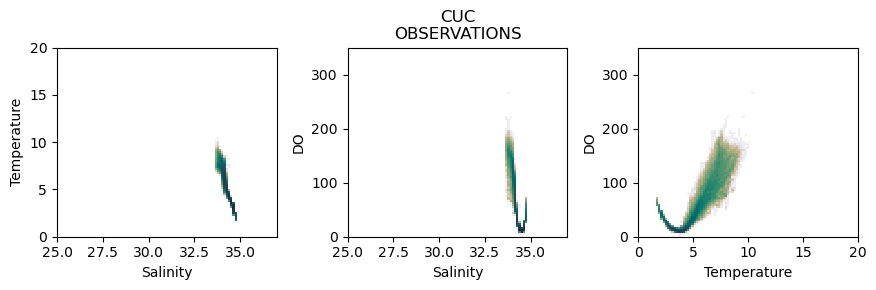

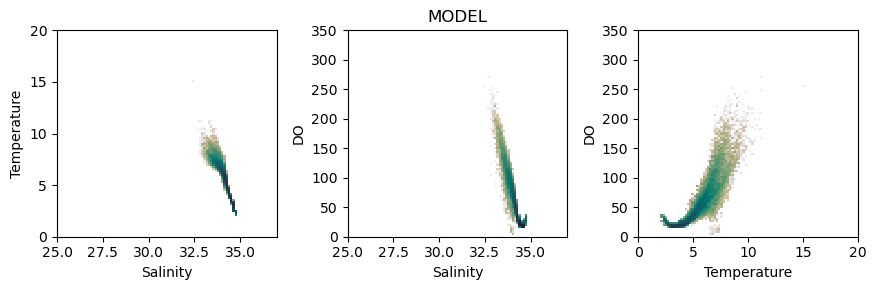

In [37]:
r='CUC'
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('CUC\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

# Property profiles by region

In [50]:
def profiles(tracer,r,colour,ax):
    if tracer == 'Salinity':
        t = 'SA'
        unit = 'g/kg'
    elif tracer == 'Temperature':
        t = 'CT'
        unit = '$^{\circ} C$'
    elif tracer == 'DO':
        t = 'DO (uM)'
        unit = 'uM'
    elif tracer == 'NO3':
        t = 'NO3 (uM)'
        unit = 'uM'
    elif tracer == 'TA':
        t = 'TA (uM)'
        unit = 'uM'
    elif tracer == 'DIC':
        t = 'DIC (uM)'
        unit = 'uM'

    binbin = np.arange((np.min(obs['z'][(obs.region==r)&(np.isfinite(obs[t]))])),0,10)
    avg_obs, bins, _ = stat.binned_statistic(obs['z'][(obs.region==r)&(np.isfinite(obs[t]))],obs[t][(obs.region==r)&(np.isfinite(obs[t]))],statistic='mean',bins=binbin)
    avg_mod, bins, _ = stat.binned_statistic(mod['z'][(mod.region==r)&(np.isfinite(mod[t]))],mod[t][(mod.region==r)&(np.isfinite(mod[t]))],statistic='mean',bins=binbin)

    ax.plot(avg_mod, bins[:-1], c=colour,lw=2,ls='dashed')
    ax.plot(avg_obs, bins[:-1],c=colour,lw=2,label=r)

    title = tracer
    ax.set_title(title)
    ax.set_xlabel(unit)
    # ax.set_yticks([])
    # ax.set_ylim([-3000,10])


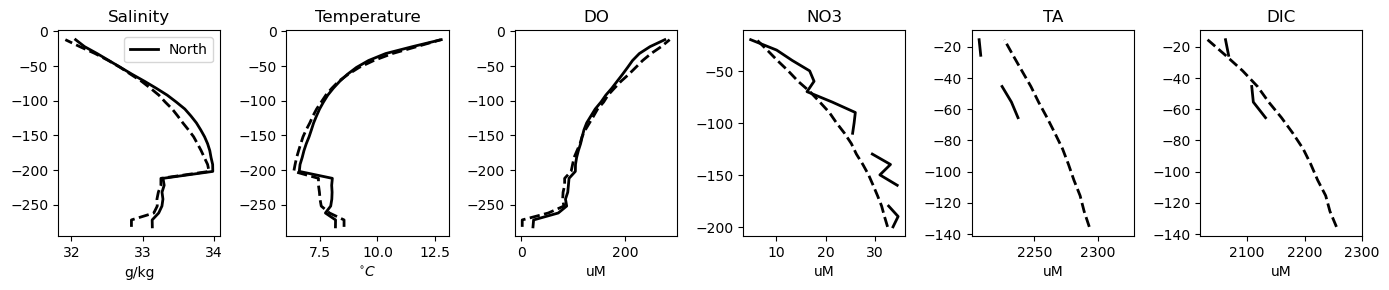

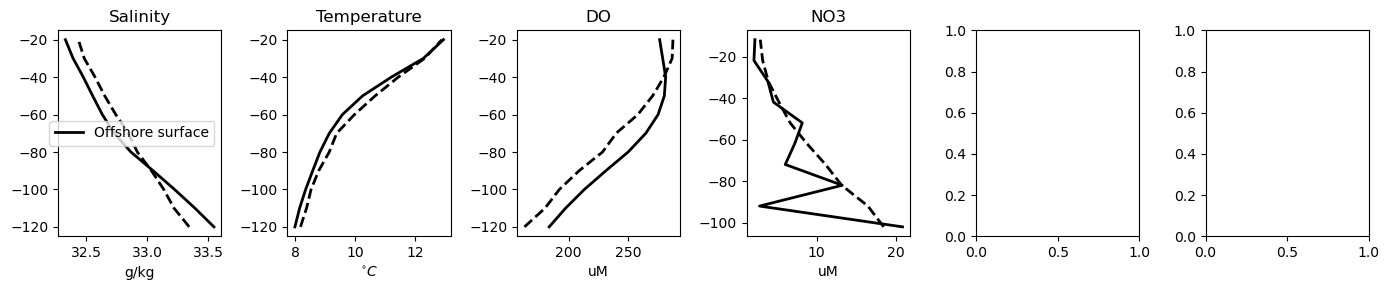

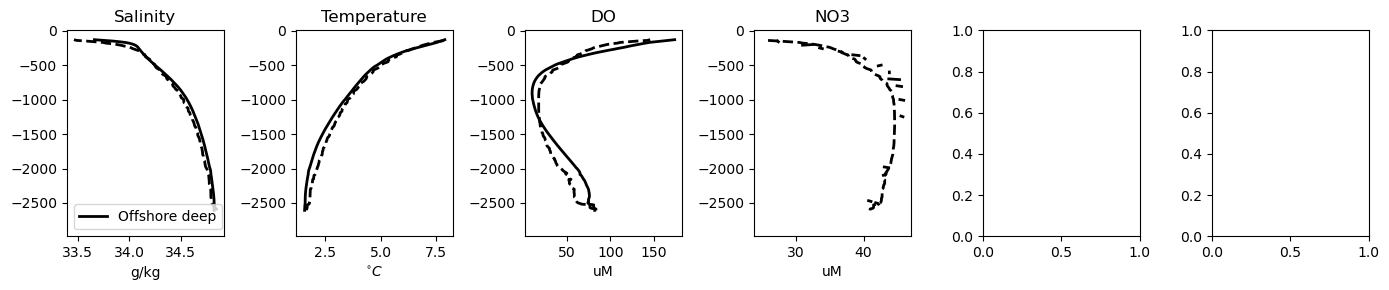

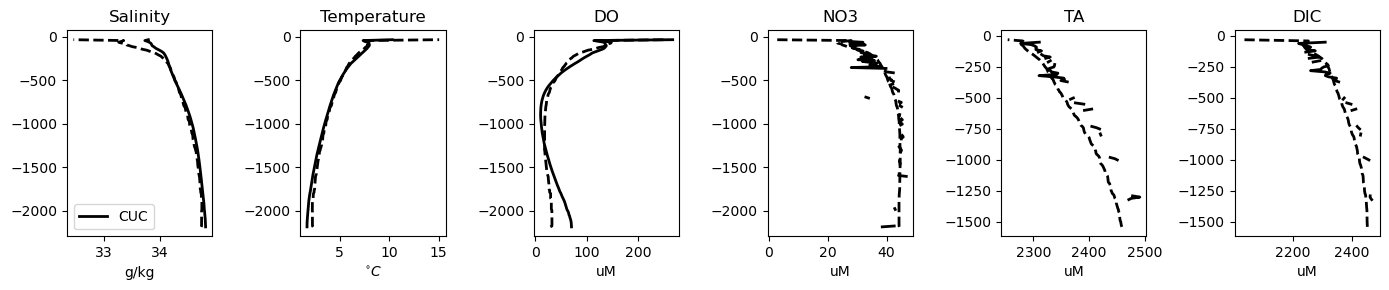

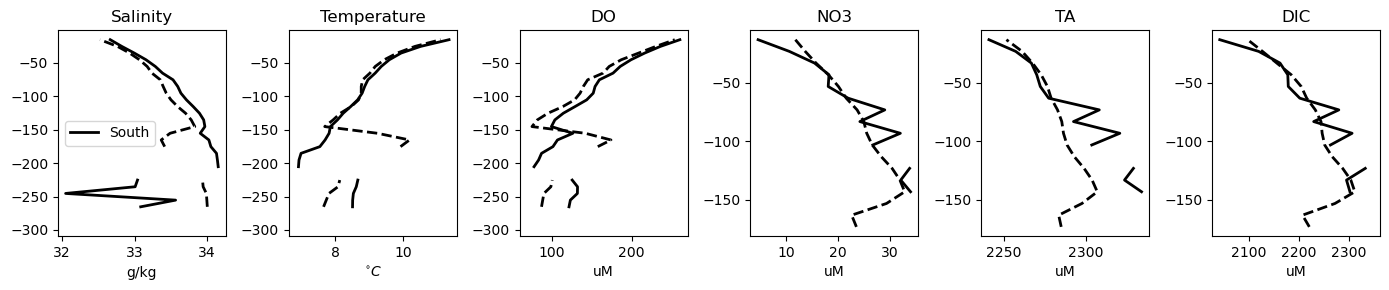

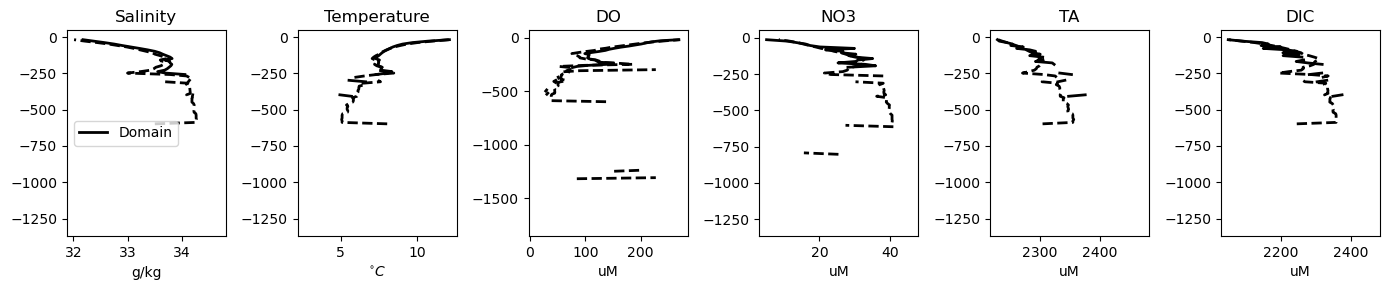

In [51]:
r='North'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
profiles('DIC',r,'k',ax[5])
ax[0].legend()
plt.tight_layout()


r='Offshore surface'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
# profiles('TA','k',r,ax[4])
# profiles('DIC',r,'k',ax[5])
ax[0].legend()
plt.tight_layout()


r='Offshore deep'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
# profiles('TA',r,'k',ax[4])
# profiles('DIC',r,'k',ax[5])
ax[0].legend()
plt.tight_layout()


r='CUC'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
profiles('DIC',r,'k',ax[5])
ax[0].legend()
plt.tight_layout()

r='South'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
profiles('DIC',r,'k',ax[5])
ax[0].legend()
plt.tight_layout()

r='Domain'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
profiles('DIC',r,'k',ax[5])
ax[0].legend()
plt.tight_layout()


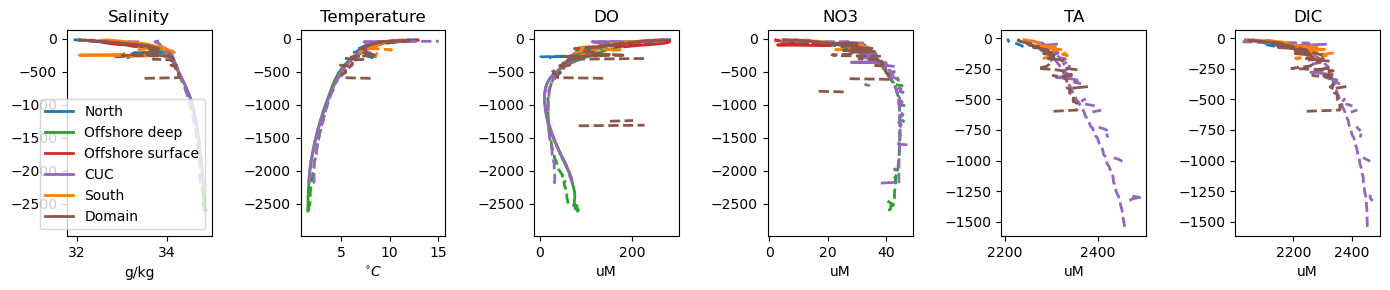

In [52]:
r='North'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'tab:blue', ax[0])
profiles('Temperature',r,'tab:blue', ax[1])
profiles('DO',r,'tab:blue', ax[2])
profiles('NO3',r,'tab:blue', ax[3])
profiles('TA',r,'tab:blue', ax[4])
profiles('DIC',r,'tab:blue',ax[5])

r='Offshore deep'
profiles('Salinity',r,'tab:green',ax[0])
profiles('Temperature',r,'tab:green',ax[1])
profiles('DO',r,'tab:green',ax[2])
profiles('NO3',r,'tab:green',ax[3])
# profiles('TA',r,'tab:green',ax[4])
# profiles('DIC',r,'tab:green',ax[5])

r='Offshore surface'
profiles('Salinity',r,'tab:red',ax[0])
profiles('Temperature',r,'tab:red',ax[1])
profiles('DO',r,'tab:red',ax[2])
profiles('NO3',r,'tab:red',ax[3])
# profiles('TA',r,'tab:red',ax[4])
# profiles('DIC',r,'tab:red',ax[5])

r='CUC'
profiles('Salinity',r,'tab:purple',ax[0])
profiles('Temperature',r,'tab:purple',ax[1])
profiles('DO',r,'tab:purple',ax[2])
profiles('NO3',r,'tab:purple',ax[3])
profiles('TA',r,'tab:purple',ax[4])
profiles('DIC',r,'tab:purple',ax[5])
ax[0].legend()

r='South'
profiles('Salinity',r,'tab:orange',ax[0])
profiles('Temperature',r,'tab:orange',ax[1])
profiles('DO',r,'tab:orange',ax[2])
profiles('NO3',r,'tab:orange',ax[3])
profiles('TA',r,'tab:orange',ax[4])
profiles('DIC',r,'tab:orange',ax[5])
ax[0].legend()

r='Domain'
profiles('Salinity',r,'tab:brown',ax[0])
profiles('Temperature',r,'tab:brown',ax[1])
profiles('DO',r,'tab:brown',ax[2])
profiles('NO3',r,'tab:brown',ax[3])
profiles('TA',r,'tab:brown',ax[4])
profiles('DIC',r,'tab:brown',ax[5])
ax[0].legend()

plt.tight_layout()

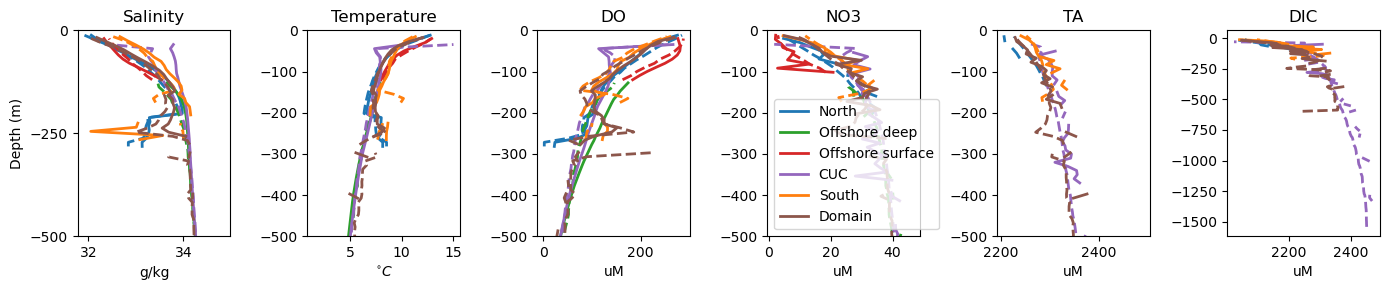

In [53]:
r='North'
fig, ax = plt.subplots(1,6, figsize=(14,3))
profiles('Salinity',r,'tab:blue', ax[0])
profiles('Temperature',r,'tab:blue', ax[1])
profiles('DO',r,'tab:blue', ax[2])
profiles('NO3',r,'tab:blue', ax[3])
profiles('TA',r,'tab:blue', ax[4])
profiles('DIC',r,'tab:blue',ax[5])

r='Offshore deep'
profiles('Salinity',r,'tab:green',ax[0])
profiles('Temperature',r,'tab:green',ax[1])
profiles('DO',r,'tab:green',ax[2])
profiles('NO3',r,'tab:green',ax[3])
# profiles('TA',r,'tab:green',ax[4])
# profiles('DIC',r,'tab:green',ax[5])

r='Offshore surface'
profiles('Salinity',r,'tab:red',ax[0])
profiles('Temperature',r,'tab:red',ax[1])
profiles('DO',r,'tab:red',ax[2])
profiles('NO3',r,'tab:red',ax[3])
# profiles('TA',r,'tab:red',ax[4])
# profiles('DIC',r,'tab:red',ax[5])

r='CUC'
profiles('Salinity',r,'tab:purple',ax[0])
profiles('Temperature',r,'tab:purple',ax[1])
profiles('DO',r,'tab:purple',ax[2])
profiles('NO3',r,'tab:purple',ax[3])
profiles('TA',r,'tab:purple',ax[4])
profiles('DIC',r,'tab:purple',ax[5])

r='South'
profiles('Salinity',r,'tab:orange',ax[0])
profiles('Temperature',r,'tab:orange',ax[1])
profiles('DO',r,'tab:orange',ax[2])
profiles('NO3',r,'tab:orange',ax[3])
profiles('TA',r,'tab:orange',ax[4])
profiles('DIC',r,'tab:orange',ax[5])

r='Domain'
profiles('Salinity',r,'tab:brown',ax[0])
profiles('Temperature',r,'tab:brown',ax[1])
profiles('DO',r,'tab:brown',ax[2])
profiles('NO3',r,'tab:brown',ax[3])
profiles('TA',r,'tab:brown',ax[4])
profiles('DIC',r,'tab:brown',ax[5])

plt.tight_layout()
ax[3].legend()

ax[0].set_ylabel('Depth (m)')
# ax[0].set_yticks([-500,-400,-300,-200,-100,0])
ax[0].set_yticks(np.linspace(-1000,0,5))

ax[0].set_ylim([-500,0])
ax[1].set_ylim([-500,0])
ax[2].set_ylim([-500,0])
ax[3].set_ylim([-500,0])
ax[4].set_ylim([-500,0])
plt.tight_layout()